# Faster-R-CNN


## Setup - this shouldn't be changed, only re-executed if need be

### Clone, update and import the repo

In [0]:
repo_name = "uj_cv_course"
repo_url = f"https://github.com/mprzewie/{repo_name}"
!if [ -d $repo_name ]; then rm -Rf $repo_name; fi
!git clone $repo_url
import sys
if repo_name not in sys.path:
  sys.path.append(repo_name)


Cloning into 'uj_cv_course'...
remote: Enumerating objects: 233, done.
remote: Counting objects: 100% (233/233), done.
remote: Compressing objects: 100% (167/167), done.
remote: Total 233 (delta 117), reused 172 (delta 59), pack-reused 0
Receiving objects: 100% (233/233), 2.00 MiB | 1.86 MiB/s, done.
Resolving deltas: 100% (117/117), done.


### Install the dependencies

`requirements.txt` from the repo should be our source of truth regarding package versions.

In [0]:
!pip install -r uj_cv_course/requirements.txt
import os
os.kill(os.getpid(), 9) #restart runtima - konieczny aby załadować poprawnie powyższe paczki

     |████████████████████████████████| 61kB 2.0MB/s 
     |████████████████████████████████| 2.1MB 7.9MB/s 
     |████████████████████████████████| 6.7MB 47.5MB/s 
     |████████████████████████████████| 25.2MB 129kB/s 
     |████████████████████████████████| 163kB 54.7MB/s 
     |████████████████████████████████| 10.1MB 26.9MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.5.1-cp36-none-any.whl size=11768 sha256=6879f0b5211c18e8d768067f3c0138d13238a70c135f76fa2ab6b0d4a71dcaac
  Stored in directory: /root/.cache/pip/wheels/52/0c/8e/58d91f29f0f8cbb45231a145312939a5423dc82c61cc731361
Successfully built efficientnet-pytorch
ERROR: torchvision 0.4.1 has requirement torch==1.3.0, but you'll have torch 1.3.1 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1

In [0]:
# this autoreloads the code
%load_ext autoreload
%autoreload 2

### Mount the google drive with data

In [0]:
from google.colab import drive
from pathlib import Path
mnt_path = "/content/drive/"
drive.mount(mnt_path)
# !ls /content/drive
project_path = list(Path(mnt_path).glob("*/uj_cv_course/"))[0]
data_path = project_path / "data_pickled"
# print("data is at", data_path)
# data_path = Path('/content/drive/My Drive/ANN/RO/Projekt/uj_cv_course/data_pickled')

train_path = data_path / "train_1_ids_no_transform.pkl"
test_path = data_path / "test_1_ids_no_transform.pkl"
train_path, test_path

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


(PosixPath('/content/drive/My Drive/uj_cv_course/data_pickled/train_1_ids_no_transform.pkl'),
 PosixPath('/content/drive/My Drive/uj_cv_course/data_pickled/test_1_ids_no_transform.pkl'))

## Experiments start here



In [0]:
%cd '/content/uj_cv_course'
import torch
from project.utils.ds.dataset import BoxedExamplesDataset, transform_chain, LazyMaskedExamplesDataset
from project.utils.ds import transforms as tr
from project.utils.ds.images import is_grayscale
import numpy as np
from torchvision.transforms import Compose
from project.utils.ds.dataset import transform_chain
import numpy as np
from torchvision import transforms as trtv
import matplotlib.pyplot as plt
import json

/content/uj_cv_course


### Load the datasets

In [0]:
def crop_to_exact_size(example, x_size, y_size, retries = 10):    
  w, h = example.image.size
  c_w = x_size / w
  c_h = y_size / h
  assert c_w <= 1
  assert c_h <= 1

  x_min = np.random.uniform(0, 1 - c_w)
  y_min = np.random.uniform(0, 1 - c_h)

  res = tr.crop(
      example,
      x_min,
      y_min,
      x_min + c_w,
      y_min + c_h 
      
  )
  return res


def normalize(ex):
  i, l = ex
  return trtv.Normalize([0.2, 0.2, 0.2], [0.5, 0.5, 0.5])(i), l

In [0]:

from project.utils.ds import transforms as tr
from project.utils.ds import random_transforms as rnd

transform_chain = [
    tr.to_grayscale,
    tr.flip_color_on_intensity_heuristic,
    tr.max_pixel_to_255,
    # rnd.random_transform(tr.rotate, rnd.rotate_90_sampler()),
    # rnd.random_transform(tr.rotate, rnd.rotate_sampler(amplitude=10)),
    tr.resize_to_min_300,
    tr.to_rgb,
    # rnd.random_transform(tr.crop, rnd.constant_crop_size_sampler(crop_size=256/300)),
    lambda ex: crop_to_exact_size(ex, 300, 300),

]

In [0]:
def retransform(ex, transform, retries=None):
  if retries is not None and retries < 0:
    raise ValueError(ex.name)
  ex_tran = transform(ex)
  if len(ex_tran.boxes) == 0:
    return retransform(ex, transform, retries-1 if retries is not None else None)
  return ex_tran

In [0]:
import pickle

with train_path.open("rb") as f:
  ds = pickle.load(f)

with test_path.open("rb") as f:
  ds_test = pickle.load(f)

ds.examples = [ex for ex in ds.examples if not ex.name.startswith("7b38")]

len(ds), len(ds_test)

(669, 65)

In [0]:
any(
    len(ex.boxes) == 0
    for ex in ds
)

False

#### Visualize some examples

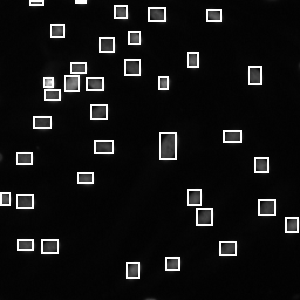

In [0]:
ex = ds.examples[1]

ex = Compose(transform_chain)(ex)

ex.vis_boxes()

In [0]:
# evaluation utils
def gather_metrics(
    model, dl_train, dl_val, device, max_n_batches=5
):

  coco_train = tv_rcnn.coco_eval_metrics(evaluate(
    model, dl_train, device
  )
)
  coco_val = tv_rcnn.coco_eval_metrics(
      evaluate(
        model, dl_val, device
      )
  )


  losses_train = tv_rcnn.evaluate_for_losses(
      model, dl_train, device, max_n_batches=max_n_batches
  )
  losses_val = tv_rcnn.evaluate_for_losses(
      model, dl_val, device, max_n_batches=max_n_batches
  )

  return dict(
    train=dict(
        **losses_train,
        **coco_train
    ),
    val=dict(
        **losses_val,
        **coco_val
    )
)

def plot_metrics_histories(
    history, # List[Dict[str, float]],
):
  metric_names = history[0]["train"].keys()
  print(list(metric_names))
  fig, axes = plt.subplots(len(metric_names), figsize=(10, len(metric_names) * 10) )

  epochs_inds = list(range(len(history)))

  for i, metric_name in enumerate(metric_names):
    ax = axes[i]

    for fold in ["train", "val"]:
      ax.plot(
        epochs_inds, 
        [
        h[fold][metric_name] for h in history
        ],
        label=fold
      )
      ax.set_title(metric_name)
      ax.legend()
  return fig

def visualize_example_result(
    example_original,
    example_input, example_output,
    epoch=None
):

  h, w = example_original.image.size
  size = max(h, w)
  thickness = int(size // 150)

  fig, ax = plt.subplots(2, 2, figsize=(10,10))
  ax[0,0].imshow(example_original.vis_boxes(thickness=thickness))
  ax[0,0].set_title(f"{example_original.id} {example_original.name[:10]} original")

  ax[1, 0].imshow(example_input.vis_boxes(thickness=thickness))
  ax[1, 0].set_title("input to model with boxes ")

  ax[0, 1].imshow(example_input.image)
  ax[0, 1].set_title("input to model w/o boxes")

  ax[1, 1].imshow(example_output.vis_boxes(thickness=thickness))
  ax[1,1].set_title(f"epoch {epoch} model output")
  return fig

## Play with Faster-RCNN

In [0]:
%cd /content/uj_cv_course/
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from project.utils.models import tv_rcnn
from torch.optim import Adam
from torch.utils.data import DataLoader

from project.utils.tv_det_ref import utils
from project.utils.tv_det_ref.engine import train_one_epoch, evaluate
from project.utils.ds.dataset import BoxedExamplesDataset

/content/uj_cv_course


In [0]:
example_transform = lambda ex: retransform(ex, Compose(transform_chain), None)
to_model = Compose([
  tv_rcnn.to_model_input,
  normalize,
])


total_transform = Compose([
  example_transform,
  to_model
])


ds_train = BoxedExamplesDataset(
    ds.examples[:600],
    total_transform
)
ds_val = BoxedExamplesDataset(
    ds.examples[600:],
    total_transform
)


dl_train, dl_val = [torch.utils.data.DataLoader(
        ds_, batch_size=4, shuffle=True, #batch_sampler=torch.utils.data.BatchSampler(torch.utils.data.RandomSampler(ds_), 16),
        collate_fn=utils.collate_fn
)
for ds_ in [ds_train, ds_val]
]


len(ds_train), len(ds_val), len(ds)

(600, 69, 669)

In [0]:
val_inds = [int(l["image_id"].item()) for (i, l) in ds_val]

ds_val_unaugmented = BoxedExamplesDataset(
    [ex for ex in ds.examples if ex.id in val_inds],
    trtv.Compose([
      tr.to_grayscale,
      tr.flip_color_on_intensity_heuristic,
      tr.max_pixel_to_255,
      tr.to_rgb,
      tv_rcnn.to_model_input
  ])
)
dl_val_unaugmented = torch.utils.data.DataLoader(
        ds_val_unaugmented, batch_size=1,
        collate_fn=utils.collate_fn
)

In [0]:
from torchvision.models.detection.rpn import AnchorGenerator
from project.utils.models.efficientnet import faster_rcnn_efficientnet_fpn

anchors = AnchorGenerator(
    sizes=(8, 16, 32, 64, 128, 256)
)

# model = fasterrcnn_resnet50_fpn(
#     pretrained=False, 
#     num_classes=2, #możliwe że wystarczy jedna klasa (zależy od implementacji fpn - w retinie automatycznie dodawano klasę null) #nope, nie wystarczy
#     pretrained_backbone=True,
#     rpn_anchor_generator=anchors
#   )

model = faster_rcnn_efficientnet_fpn(
    "efficientnet-b3",
    rpn_anchor_generator=anchors
)
opt = Adam(model.parameters(), lr=4e-6, )
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

Downloading: "http://storage.googleapis.com/public-models/efficientnet/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/checkpoints/efficientnet-b7-dcc49843.pth
100%|██████████| 254M/254M [00:03<00:00, 77.8MB/s]


Loaded pretrained weights for efficientnet-b7


Downloading: "http://storage.googleapis.com/public-models/efficientnet/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/checkpoints/efficientnet-b3-5fb5a3c3.pth
100%|██████████| 47.1M/47.1M [00:00<00:00, 104MB/s] 


Loaded pretrained weights for efficientnet-b3


device(type='cuda', index=0)

In [0]:
n_epochs = 100
model = model.to(device)

In [0]:
experiment_path = project_path / "experiments" / "vis_history" / "faster_rcnn_efficientnet_b3"
experiment_path.mkdir(exist_ok=True, parents=True)

renders_path = experiment_path / "renders"
renders_path.mkdir(exist_ok=True, parents=True)

latest_state_path = experiment_path / "latest_state.pth"

if latest_state_path.exists():
  checkpoint = torch.load(latest_state_path)
  epoch = checkpoint["epoch"]
  hist = checkpoint["loss_history"]
  model.load_state_dict(checkpoint['model_state_dict'])
  opt.load_state_dict(checkpoint['optimizer_state_dict'])
  print(f"loading model from epoch {epoch}")

else:
  print("starting training from scratch")
  epoch = 0
  hist = [
    gather_metrics(model, dl_train, dl_val, device)
  ]


predictions = tv_rcnn.model_predictions_from_loader(
    model, dl_val_unaugmented, device, max_n_batches=4, normalization_transform=trtv.Normalize([0.2, 0.2, 0.2], [0.5, 0.5, 0.5])
    )
for (
  ei, eou
) in predictions:
  eor = [e for e in ds.examples if e.id == ei.id][0]
  fig = visualize_example_result(eor, ei, eou, epoch=epoch)
  fig.savefig(renders_path / f"{epoch}_{ei.id}_{ei.name}.png")

for e in range(epoch, n_epochs):
  model.train()
  train_one_epoch(
      model=model,
      optimizer=opt,
      data_loader=dl_train,
      device=device,
      epoch=e,
      print_freq=25
  )

  model.eval()
  metrics_dict = gather_metrics(model, dl_train, dl_val, device)
  hist.append(metrics_dict)

  predictions = tv_rcnn.model_predictions_from_loader(
      model, dl_val_unaugmented, device, max_n_batches=8, normalization_transform=trtv.Normalize([0.2, 0.2, 0.2], [0.5, 0.5, 0.5])
      )
  for (
    ei, eou
  ) in predictions:
    eor = [e for e in ds.examples if e.id == ei.id][0]
    fig = visualize_example_result(eor, ei, eou, epoch=e+1 )
    fig.savefig(renders_path / f"{e+1}_{ei.id}_{eor.name}.png")

  torch.save({
            "epoch": e,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": opt.state_dict(),
            "loss_history": hist
            }, 
    experiment_path / "latest_state.pth"
  )

  fig = plot_metrics_histories(hist)
  fig.savefig(experiment_path / "metrics.png")
  
fig.show()

loading model from epoch 66
Epoch: [66]  [  0/150]  eta: 0:03:13  lr: 0.000004  loss: 0.5028 (0.5028)  loss_classifier: 0.1616 (0.1616)  loss_box_reg: 0.1320 (0.1320)  loss_objectness: 0.0416 (0.0416)  loss_rpn_box_reg: 0.1675 (0.1675)  time: 1.2882  data: 0.0349  max mem: 10731
Epoch: [66]  [ 25/150]  eta: 0:01:35  lr: 0.000004  loss: 0.2501 (0.2901)  loss_classifier: 0.0971 (0.1102)  loss_box_reg: 0.0925 (0.0960)  loss_objectness: 0.0181 (0.0221)  loss_rpn_box_reg: 0.0402 (0.0617)  time: 0.7392  data: 0.0596  max mem: 10771
Epoch: [66]  [ 50/150]  eta: 0:01:14  lr: 0.000004  loss: 0.2814 (0.3061)  loss_classifier: 0.1156 (0.1187)  loss_box_reg: 0.1008 (0.1015)  loss_objectness: 0.0237 (0.0243)  loss_rpn_box_reg: 0.0526 (0.0616)  time: 0.7250  data: 0.0450  max mem: 10854
Epoch: [66]  [ 75/150]  eta: 0:00:55  lr: 0.000004  loss: 0.3017 (0.3044)  loss_classifier: 0.1192 (0.1199)  loss_box_reg: 0.0994 (0.1015)  loss_objectness: 0.0208 (0.0241)  loss_rpn_box_reg: 0.0404 (0.0589)  time: 0

  0%|          | 0/150 [00:00<?, ?it/s]

Test:  [17/18]  eta: 0:00:00  model_time: 0.1948 (0.1877)  evaluator_time: 0.1543 (0.1880)  time: 0.4277  data: 0.0501  max mem: 10854
Test: Total time: 0:00:07 (0.4277 s / it)
Averaged stats: model_time: 0.1948 (0.1877)  evaluator_time: 0.1543 (0.1880)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.300
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.515
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.312
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.360
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.049
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.020
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.168
 Average Recall     (AR) @[ IoU=0.50:0

 28%|██▊       | 5/18 [00:01<00:04,  3.19it/s]


['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg', 'Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ]', 'Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ]', 'Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ]', 'Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ]', 'Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ]', 'Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ]', 'Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ]', 'Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ]', 'Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ]', 'Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ]', 'Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ]', 'Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] ']
Epoch: [67]  [  0/150]  eta: 0:01:49

  0%|          | 0/150 [00:00<?, ?it/s]

Test:  [17/18]  eta: 0:00:00  model_time: 0.1945 (0.1874)  evaluator_time: 0.1841 (0.1771)  time: 0.4064  data: 0.0400  max mem: 11308
Test: Total time: 0:00:07 (0.4065 s / it)
Averaged stats: model_time: 0.1945 (0.1874)  evaluator_time: 0.1841 (0.1771)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.283
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.481
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.299
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.350
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.022
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.019
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.164
 Average Recall     (AR) @[ IoU=0.50:0

 28%|██▊       | 5/18 [00:01<00:04,  3.22it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg', 'Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ]', 'Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ]', 'Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ]', 'Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ]', 'Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ]', 'Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ]', 'Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ]', 'Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ]', 'Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ]', 'Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ]', 'Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ]', 'Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] ']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Epoch: [68]  [  0/150]  eta: 0:01:50  lr: 0.000004  loss: 0.2270 (0.2270)  loss_classifier: 0.0963 (0.0963)  loss_box_reg: 0.0726 (0.0726)  loss_objectness: 0.0187 (0.0187)  loss_rpn_box_reg: 0.0393 (0.0393)  time: 0.7398  data: 0.0431  max mem: 11308
Epoch: [68]  [ 25/150]  eta: 0:01:30  lr: 0.000004  loss: 0.2533 (0.2640)  loss_classifier: 0.0995 (0.1038)  loss_box_reg: 0.0790 (0.0893)  loss_objectness: 0.0196 (0.0202)  loss_rpn_box_reg: 0.0514 (0.0507)  time: 0.7289  data: 0.0458  max mem: 11308
Epoch: [68]  [ 50/150]  eta: 0:01:12  lr: 0.000004  loss: 0.2749 (0.2840)  loss_classifier: 0.1061 (0.1127)  loss_box_reg: 0.1048 (0.0975)  loss_objectness: 0.0191 (0.0219)  loss_rpn_box_reg: 0.0465 (0.0519)  time: 0.7282  data: 0.0475  max mem: 11308
Epoch: [68]  [ 75/150]  eta: 0:00:54  lr: 0.000004  loss: 0.3298 (0.2967)  loss_classifier: 0.1271 (0.1191)  loss_box_reg: 0.1092 (0.1007)  loss_objectness: 0.0230 (0.0233)  loss_rpn_box_reg: 0.0527 (0.0537)  time: 0.7235  data: 0.0441  max mem

  0%|          | 0/150 [00:00<?, ?it/s]

Test:  [17/18]  eta: 0:00:00  model_time: 0.1955 (0.1881)  evaluator_time: 0.2064 (0.1968)  time: 0.4280  data: 0.0413  max mem: 11308
Test: Total time: 0:00:07 (0.4281 s / it)
Averaged stats: model_time: 0.1955 (0.1881)  evaluator_time: 0.2064 (0.1968)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.296
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.513
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.309
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.362
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.020
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.018
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.164
 Average Recall     (AR) @[ IoU=0.50:0

 28%|██▊       | 5/18 [00:01<00:04,  3.23it/s]


['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg', 'Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ]', 'Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ]', 'Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ]', 'Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ]', 'Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ]', 'Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ]', 'Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ]', 'Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ]', 'Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ]', 'Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ]', 'Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ]', 'Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] ']
Epoch: [69]  [  0/150]  eta: 0:01:49

  0%|          | 0/150 [00:00<?, ?it/s]

Test:  [17/18]  eta: 0:00:00  model_time: 0.1954 (0.1890)  evaluator_time: 0.1288 (0.1969)  time: 0.4305  data: 0.0427  max mem: 11308
Test: Total time: 0:00:07 (0.4305 s / it)
Averaged stats: model_time: 0.1954 (0.1890)  evaluator_time: 0.1288 (0.1969)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.313
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.561
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.327
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.370
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.053
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.018
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.165
 Average Recall     (AR) @[ IoU=0.50:0

 28%|██▊       | 5/18 [00:01<00:04,  3.15it/s]


['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg', 'Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ]', 'Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ]', 'Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ]', 'Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ]', 'Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ]', 'Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ]', 'Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ]', 'Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ]', 'Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ]', 'Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ]', 'Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ]', 'Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] ']
Epoch: [70]  [  0/150]  eta: 0:01:47

  0%|          | 0/150 [00:00<?, ?it/s]

Test:  [17/18]  eta: 0:00:00  model_time: 0.1954 (0.1882)  evaluator_time: 0.1408 (0.1885)  time: 0.4191  data: 0.0406  max mem: 11308
Test: Total time: 0:00:07 (0.4191 s / it)
Averaged stats: model_time: 0.1954 (0.1882)  evaluator_time: 0.1408 (0.1885)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.302
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.532
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.307
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.365
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.037
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.018
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.166
 Average Recall     (AR) @[ IoU=0.50:0

 28%|██▊       | 5/18 [00:01<00:04,  3.04it/s]


['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg', 'Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ]', 'Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ]', 'Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ]', 'Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ]', 'Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ]', 'Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ]', 'Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ]', 'Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ]', 'Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ]', 'Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ]', 'Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ]', 'Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] ']
Epoch: [71]  [  0/150]  eta: 0:01:47

  0%|          | 0/150 [00:00<?, ?it/s]

Test:  [17/18]  eta: 0:00:00  model_time: 0.1959 (0.1889)  evaluator_time: 0.1259 (0.1903)  time: 0.4236  data: 0.0426  max mem: 11308
Test: Total time: 0:00:07 (0.4237 s / it)
Averaged stats: model_time: 0.1959 (0.1889)  evaluator_time: 0.1259 (0.1903)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.298
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.508
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.316
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.360
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.021
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.018
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.161
 Average Recall     (AR) @[ IoU=0.50:0

 28%|██▊       | 5/18 [00:01<00:04,  3.24it/s]


['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg', 'Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ]', 'Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ]', 'Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ]', 'Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ]', 'Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ]', 'Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ]', 'Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ]', 'Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ]', 'Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ]', 'Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ]', 'Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ]', 'Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] ']
Epoch: [72]  [  0/150]  eta: 0:01:49

  0%|          | 0/150 [00:00<?, ?it/s]

Test:  [17/18]  eta: 0:00:00  model_time: 0.1955 (0.1885)  evaluator_time: 0.1275 (0.1861)  time: 0.4240  data: 0.0476  max mem: 11308
Test: Total time: 0:00:07 (0.4241 s / it)
Averaged stats: model_time: 0.1955 (0.1885)  evaluator_time: 0.1275 (0.1861)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.309
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.528
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.323
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.019
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.169
 Average Recall     (AR) @[ IoU=0.50:0

 28%|██▊       | 5/18 [00:01<00:04,  3.16it/s]


['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg', 'Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ]', 'Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ]', 'Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ]', 'Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ]', 'Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ]', 'Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ]', 'Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ]', 'Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ]', 'Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ]', 'Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ]', 'Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ]', 'Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] ']
Epoch: [73]  [  0/150]  eta: 0:01:50

  0%|          | 0/150 [00:00<?, ?it/s]

Test:  [17/18]  eta: 0:00:00  model_time: 0.1960 (0.1891)  evaluator_time: 0.1555 (0.1817)  time: 0.4203  data: 0.0477  max mem: 11308
Test: Total time: 0:00:07 (0.4204 s / it)
Averaged stats: model_time: 0.1960 (0.1891)  evaluator_time: 0.1555 (0.1817)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.300
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.509
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.321
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.362
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.033
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.019
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.166
 Average Recall     (AR) @[ IoU=0.50:0

 28%|██▊       | 5/18 [00:01<00:04,  3.08it/s]


['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg', 'Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ]', 'Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ]', 'Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ]', 'Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ]', 'Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ]', 'Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ]', 'Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ]', 'Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ]', 'Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ]', 'Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ]', 'Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ]', 'Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] ']
Epoch: [74]  [  0/150]  eta: 0:01:53